In [ ]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [ ]:
%presentation_style

In [ ]:
%%capture

%set_random_seed 12

In [ ]:
%load_latex_macros

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Include title and greeting with divs</div>

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import sbi.analysis
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm.notebook import trange, tqdm

from tfl_training_sbi import mdn
from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    SIRStdScaler,
    load_sir_data,
)
from tfl_training_sbi.utils_sir import eval_sir_model

storage = default_remote_storage()
c = get_config(reload=True)


# Introduction to Neural Density Estimation with SBI

- We've seen Likelihood-free inference with ABC
- We've seen Density Estimation

Now we'll combine the idea of Likelihood-free inference with Density Estimation, i.e. Simulation-based inference (SBI)

<figure>
    <center>
    <img src="_static/images/sbi_concept_figure.png" style="width:50%"/>
    <figcaption>Fig. 1 - Schematic overview of SBI. Figure taken from Jan Boelts, 2023</figcaption>
</figure>


# Neural Density Estimation for SBI

Parameterization vs. Learning of a distribution.

Methodologies: 

- Neural Posterior Estimation (NPE) $\leftarrow$ **This notebook**
- Neural Likelihood Estimation (NLE)
- Neural Ratio Estimation (NRE)
- Neural Score Estimation (NSE)
- ...
- And even sequential variants!


## Idea of Neural Posterior Estimation

- Learn the posterior $p(\theta|x)$ of a parameter $\theta$ given data $x$ $\to$ Conditional Density Estimation
- Learn an estimator for $p(\theta|x)$ on data from the joint distribution $p(\theta, x)$
$$
p(\theta \mid x) \propto p(x \mid \theta) p(\theta) = p(\theta, x)
$$

## Sampling from the Joint Distribution

 1. Define a prior $p(\theta)$
 2. Define a simulator / generator $g(\theta)$
 3. Draw sample $\theta \sim p(\theta)$ and obtain $x = g(\theta)$, where $x\sim p(x\mid\theta)$

$$
p(\theta, x) = p(\theta) p(x \mid \theta)
$$

In [ ]:
Stick with MDN and hint that there are NFs etc. 

## Posterior decomposition

<figure>
    <center>
    <img src="_static/images/illustration_posterior.png" style="width:50%"/>
    <figcaption>Fig. 2 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Example: Neural Posterior Estimation

We will learn the parameterization of Gaussian mixture model using a neural
network.

Parameters will be adapted using the maximum likelihood principle: minimizing
the negative log-likelihood of the data under the model.

We will use a Mixture Density Network (MDN) to do so, as seen before. 

<figure>
    <center>
    <img src="_static/images/illustration_npe_mdn.png" style="width:50%"/>
    <figcaption>Fig. 3 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>


### Example Data: SIR Dataset

For this example, the SIR dataset is used. 

**Task:** Load the data and get familiar with it. Again, a pseudo simulator is
provided. 

In [2]:
# we provide a pre-computed dataset according to the differential equations
# defining the SIR model.
# the pseudo simulator draws samples at random
data_theta, data_x = load_sir_data(c.data)
sir_scaler = SIRStdScaler()
simulator = SIRSimulation(
    data_theta[:-1], data_x[:-1], transformations=Compose([sir_scaler])
)


In [3]:
# let's fix the last pair as observation
obs_theta, obs_x = torch.tensor(data_theta[-1]).unsqueeze(0), torch.tensor(
    data_x[-1]
).unsqueeze(0)
data = sir_scaler({"theta": obs_theta, "obs": obs_x})
obs_theta_z, obs_x_z = data["theta"], data["obs"]


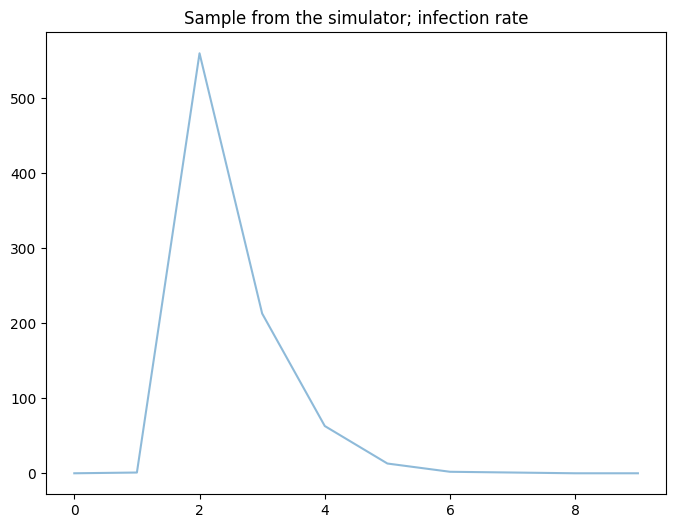

In [4]:
# todo: think about inc. the density of samples and plotting everything
# familiarize yourself with the data; feel free to call this cell several times
# as the observation is randomly sampled
plt.figure(figsize=(8, 6))
plt.plot(simulator()[1][:], "-", alpha=0.5)
plt.title("Sample from the simulator; infection rate")
plt.show()


In [5]:
# define a torch DatLoader
# preprocessing of data, e.g. standardization happens in the Dataset, i.e. simulator
sir_dataloader = DataLoader(simulator, batch_size=1024, shuffle=True, drop_last=True)


In [6]:
# initialize the mixture density network, parameterizing a
# `num_components`-component mixture of Gaussians with `features`
# features, i.e. variables
mixture_density_net = mdn.MultivariateGaussianMDN(
    features=2,
    hidden_net=nn.Sequential(
        nn.Linear(10, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
    ),
    num_components=4,
    hidden_features=16,
)


In [7]:
loss_hist = []

# fit MDN using negative log-likelihood loss
opt = torch.optim.Adam(mixture_density_net.parameters(), lr=0.001)
for e in trange(10):
    for batch in sir_dataloader:
        theta_batch, x_batch = batch["theta"], batch["obs"]

        opt.zero_grad()

        # get the mixture components
        (
            weights_of_each_gaussian,
            means,
            variances,
        ) = mixture_density_net.get_mixture_components(x_batch)

        # compute Likelihood of sample under current parameterization
        log_probs = mdn.mog_log_prob(
            theta_batch, weights_of_each_gaussian, means, variances
        )

        # compute the negative log-likelihood loss
        loss = -log_probs.sum()
        loss.backward()

        # track  the loss per batch
        loss_hist.append(loss.item())

        # update the parameters using gradient descent
        opt.step()


  0%|          | 0/10 [00:00<?, ?it/s]

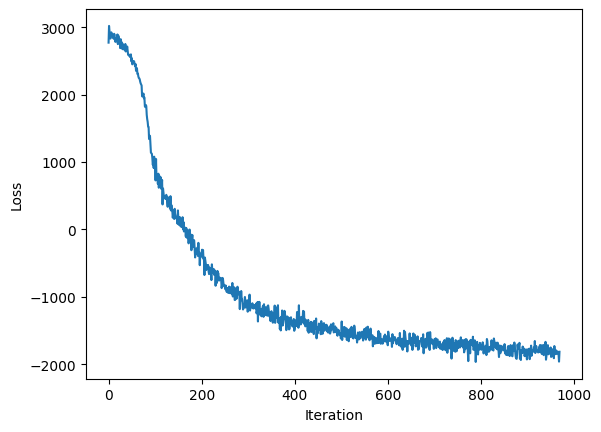

In [8]:
plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


### Inspecting the Learned Distribution

Sample `50_000` times from learned posterior distribution $\hat{p}(\theta \mid
x_o)$.

 - Following, we the samples will be re-scaled. 
 - A subset will be used to plot the resulting infection rate against the true rate. 
 - All samples will be used to plot the marginal distributions of the parameters.


In [9]:
samples = []

# get the posterior, i.e. get the mixture components
weights, means, variances = mixture_density_net.get_mixture_components(obs_x_z)

for _ in trange(50_000):
    # sample form mixture of Gaussians
    sample = mdn.mog_sample(weights, means, variances)
    samples.append(sample)

samples = torch.cat(samples).detach().numpy()


  0%|          | 0/50000 [00:00<?, ?it/s]

In [54]:
# unscale the dat params first
samples_subset = torch.tensor(samples)
samples_unscaled = sir_scaler.rescale(
    {"theta": samples_subset, "obs": torch.ones_like(samples_subset)}
)["theta"]

# eval. the SIR model for a selected number of samples
sample_obs = []
for i in trange(1_000):
    samples_obs = eval_sir_model(theta=samples_unscaled[i], population_size=1_000_000)
    sample_obs.append(samples_obs)

# stack the collected samples into a big array of shape (N, 160, 3)
sample_obs = np.stack(sample_obs, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Inspect Resulting Posterior Approximation

Plot the marginal distributions per parameter and the joint distribution of the
parameters.


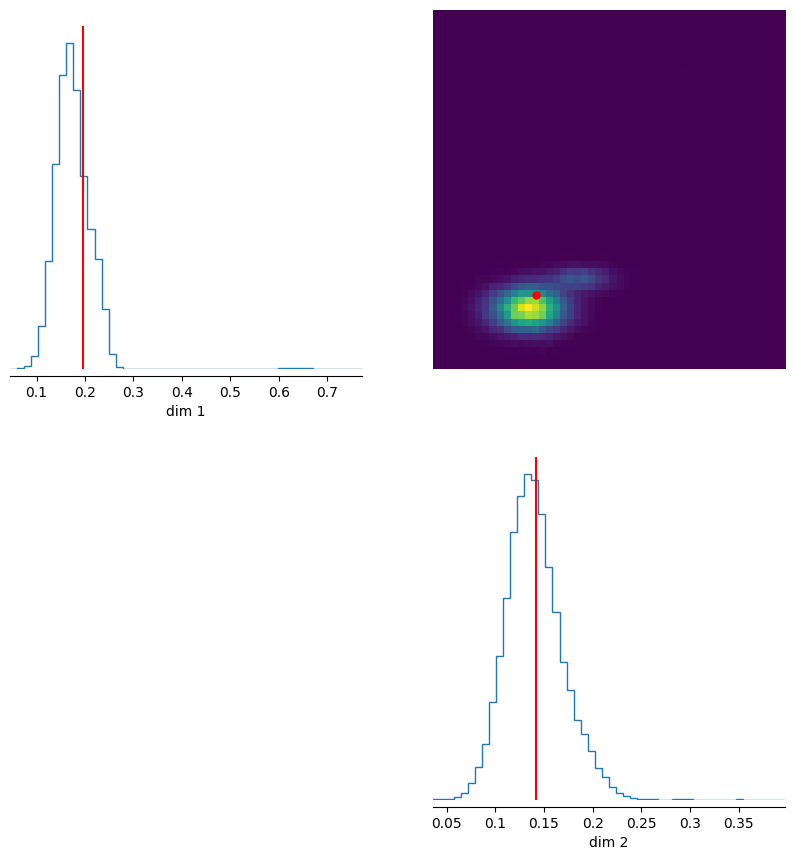

In [46]:
_ = sbi.analysis.pairplot(
    samples_unscaled, points=obs_theta, points_offdiag={"markersize": 10}, points_colors="r"
)

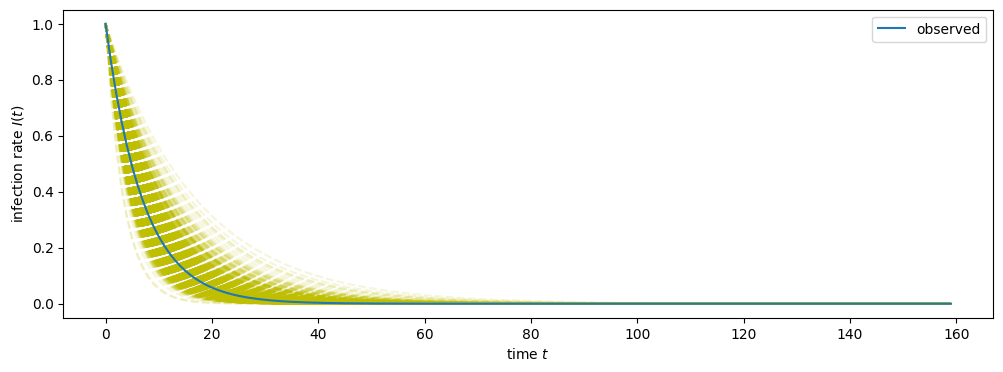

In [61]:
# eval the SIR model for the true parameters to get a full scale observation
obs_x_full_scale = eval_sir_model(theta=obs_theta.numpy()[0], population_size=1_000_000)

plt.figure(figsize=(12, 4))
plt.plot(sample_obs[:, :, 1].T, "y--", alpha=.15)
plt.plot(obs_x_full_scale[:, 1], "-", alpha=1.0, label="observed")

plt.xlabel("time $t$")
plt.ylabel("infection rate $I(t)$")
plt.legend()

plt.show()


## Treatment of Time Series Data

- Subsampling 
- Summary Statistics
- Feature Extraction via different models 

<figure>
    <center>
    <img src="_static/images/illustration_mdn_feat_extraction.png" style="width:50%"/>
    <figcaption>Fig. 4 - Pre-pending a powerful feature extractor might be necessary in order to obtain meaningful features from time series data. Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Sequential Neural * Estimation 

... note that there is such thing but don't go into depth .

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>